In [2]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
%matplotlib inline

The data files are

RegularSeasonCompactResults.csv

RegularSeasonDetailedResults.csv

Seasons.csv

Teams.csv

TourneyCompactResults.csv

TourneyDetailedResults.csv

TourneySeeds.csv

TourneySlots.csv

sample_submission.csv

# Loading all data files

In [3]:
df_seeds = pd.read_csv('TourneySeeds.csv')
df_tour_results = pd.read_csv('TourneyCompactResults.csv')
df_reg_comp_rs=pd.read_csv('RegularSeasonCompactResults.csv')
df_reg_det_rs=pd.read_csv('RegularSeasonDetailedResults.csv')
df_seasons=pd.read_csv('Seasons.csv')
df_teams=pd.read_csv('Teams.csv')
df_tour_det_results = pd.read_csv('TourneyDetailedResults.csv')
df_tour_slots = pd.read_csv('TourneySlots.csv')

In [4]:
print(df_seeds.shape)
print(df_seeds[df_seeds.Season==2016].shape)
df_seeds.head()

(2082, 3)
(68, 3)


,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_tour_results.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [6]:
print(df_reg_comp_rs.shape)
df_reg_comp_rs.tail()

(145289, 8)


,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
145284,2016,132,1114,70,1419,50,N,0
145285,2016,132,1163,72,1272,58,N,0
145286,2016,132,1246,82,1401,77,N,1
145287,2016,132,1277,66,1345,62,N,0
145288,2016,132,1386,87,1433,74,N,0


In [7]:
df_seasons.head()

,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [8]:
print(df_teams.shape)
df_teams.head()

(364, 2)


,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [9]:
df_tour_det_results.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


# Kaggle Kernel of Logistic Regression

I will try to apply the code given in the following kernel now

https://www.kaggle.com/kplauritzen/march-machine-learning-mania-2017/notebookde27b18258

Let's drop the columns we are not planning on using

In [10]:
df_tour_results.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)


In [11]:
df_tour_results.head()

,Season,Wteam,Lteam
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


Get the seeds as integers

In [12]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [13]:
df_seeds.head()

,Season,Team,n_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


## Merge seed for each team ##
We want the seeds in the same DataFrame as the game results

In [14]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

# Very elegant technique below to make the joins and get both win seed and loss seed in a single df

In [15]:
df_dummy = pd.merge(left=df_tour_results, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [16]:
df_concat.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


## Make a new DF with just the wins and losses ##

In [17]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [18]:
df_for_predictions.head()

,seed_diff,result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


# Not sure why we reshaped 

In [19]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

In [20]:
X_train

array([[ -1],
       [ -4],
       [  5],
       ..., 
       [ -1],
       [-13],
       [ -8]], dtype=int64)

In [21]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

# Train the estimator

We use logistic regression, so we have to set a C value. We can just try a bunch of different values and then choose the best one.

In [22]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5536, with best C: 0.01


# Examine the classifier predictions



In [23]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

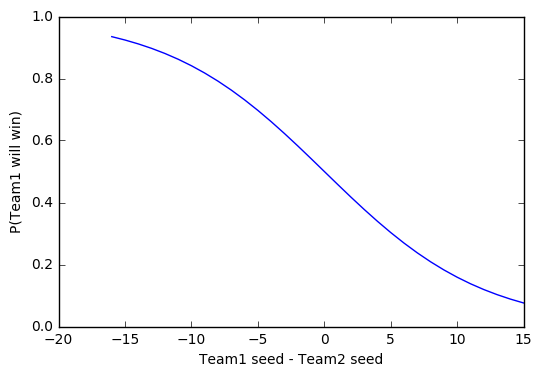

In [24]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

# Get the test data

In [25]:
df_sample_sub = pd.read_csv('sample_submission.csv')
n_test_games = len(df_sample_sub)

In [26]:
df_sample_sub.head()

,id,pred
0,2013_1103_1107,0.5
1,2013_1103_1112,0.5
2,2013_1103_1125,0.5
3,2013_1103_1129,0.5
4,2013_1103_1137,0.5


In [27]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the sample_submission.csv file. For each row, we extract the year and the teams playing. We then look up the seeds for each of those teams in that season. Finally we add the seed difference to an array.

In [28]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [29]:
X_test

array([[ -3.],
       [  6.],
       [  1.],
       ..., 
       [  5.],
       [ -5.],
       [-10.]])

# Make the predictions

In [30]:
preds = clf.predict_proba(X_test)[:,1]

In [31]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds
df_sample_sub.head()

,id,pred
0,2013_1103_1107,0.622432
1,2013_1103_1112,0.268988
2,2013_1103_1125,0.458439
3,2013_1103_1129,0.541561
4,2013_1103_1137,0.458439


In [32]:
df_sample_sub.to_csv('logreg_on_seed.csv', index=False)